<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy as sp
from scipy import signal
from datetime import timedelta, datetime

# Importing Data

In [3]:
def matlab_to_python_datetime(matlab_datenum):
    return datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366)

## Importing Minute Resolution Data

Now we import the minute resolution data, which only contains data from the one UvicSci temperature data station. We begin by getting the time information, which contains the the start and end time, and the number of measurements taken.

In [4]:
time_info = np.genfromtxt('JamesBay_temperature.dat', delimiter=" ", max_rows=3)
t0 = time_info[0]
tf = time_info[1]
N = time_info[2]

Since the time between measurements is always one minute, we can generate an array of times of measurements based on the information above.

In [5]:
incrementer = (tf-t0)/N
timearray = np.arange(t0, tf, incrementer)

We now open  the actual temperature data, and create a dataframe using the appropriate timestamps.

In [6]:
df_james = pd.read_csv('JamesBay_temperature.dat', sep=" ", skiprows=[0,1,2], names=['Temperature'])
df_james.index = [matlab_to_python_datetime(i) for i in timearray]
df_james.index = [i - timedelta(hours = 7) for i in df_james.index] #Convert to PST

Same thing for Deep Cove.

In [7]:
time_info = np.genfromtxt('DeepCove_temperature.dat', delimiter=" ", max_rows=3)
t0 = time_info[0]
tf = time_info[1]
N = time_info[2]

In [8]:
incrementer = (tf-t0)/N
timearray = np.arange(t0, tf, incrementer)

In [9]:
df_deep = pd.read_csv('DeepCove_temperature.dat', sep=" ", skiprows=[0,1,2], names=['Temperature'])
df_deep.index = [matlab_to_python_datetime(i) for i in timearray]
df_deep.index = [i - timedelta(hours = 7) for i in df_deep.index] #Convert to PST

### Obtain Required Data

The upper and lower bounds on required data.

In [10]:
lower_1 = pd.Timestamp(year=2015, month=6, day=1, hour=0)
upper_1 = pd.Timestamp(year=2015, month=9, day=30, hour=23)
lower_2 = pd.Timestamp(year=2014, month=11, day=1, hour=0)
upper_2 = pd.Timestamp(year=2015, month=2, day=28, hour=23)

Turn the data into numpy arrays.

In [23]:
data_james1 = df_james[(df_james.index>lower_1) & (df_james.index<upper_1)]
data_james2 = df_james[(df_james.index>lower_2) & (df_james.index<upper_2)]
data_james2 = data_james2.fillna(method='ffill')
james1 = np.array(data_james1['Temperature'])
james2 = np.array(data_james2['Temperature'])

In [24]:
data_deep1 = df_james[(df_deep.index>lower_1) & (df_deep.index<upper_1)]
data_deep2 = df_james[(df_deep.index>lower_2) & (df_deep.index<upper_2)]
deep1 = np.array(data_deep1['Temperature'])
deep2 = np.array(data_deep2['Temperature'])

# Design the Filter

In [63]:
def ellip_bandpass(lowcut, highcut, fs, rp, rs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = sp.signal.ellip(order, rp, rs, low, btype='lowpass')
    return b, a

def ellip_bandpass_filter(data, lowcut, highcut, fs, rp, rs, order=5):
    b, a = ellip_bandpass(lowcut, highcut, fs, rp, rs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

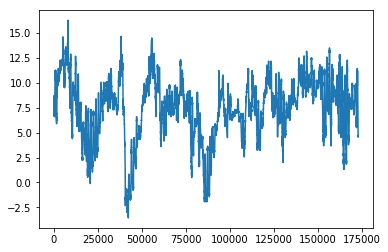

In [64]:
plt.plot(james2)

In [65]:
y = ellip_bandpass_filter(james2, lowcut=1/(25*3600), highcut=1/(23*3600),
                          fs=1/3600, rp=5, rs=40, order=5)

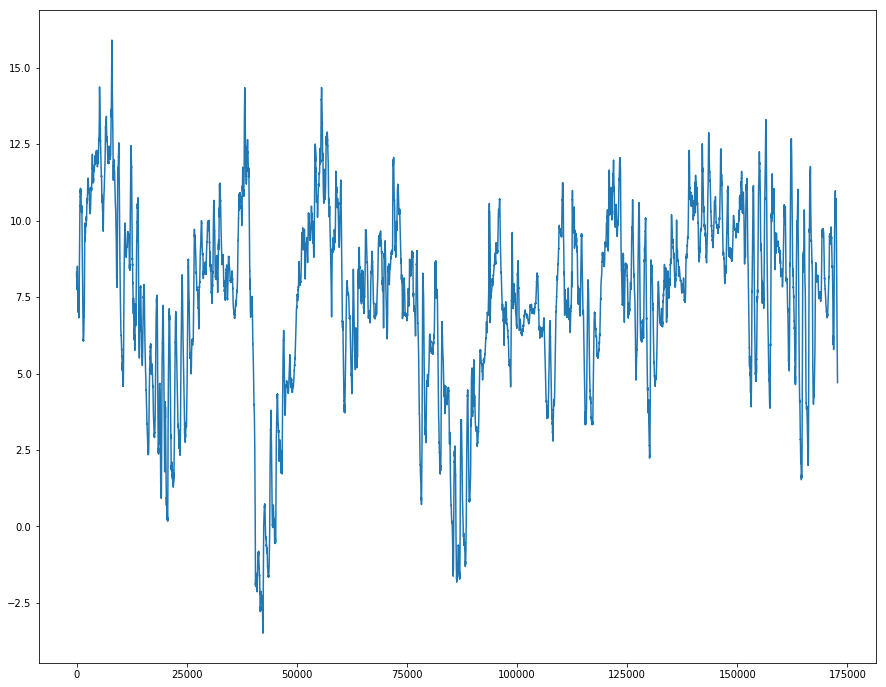

In [66]:
fig, ax = plt.subplots(figsize=(15,12))
plt.plot(y)

In [74]:
b, a = ellip_bandpass(1/(25*3600), 1/(23*3600), (1/3600), 5, 10, order=5)
w, h = signal.freqs(b, a)

/Users/lukepolson/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


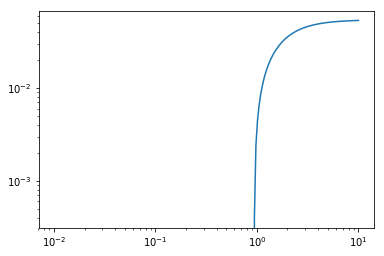

In [75]:
plt.loglog(w,h)

In [61]:
y = sp.signal.filtfilt(b, a, james2)

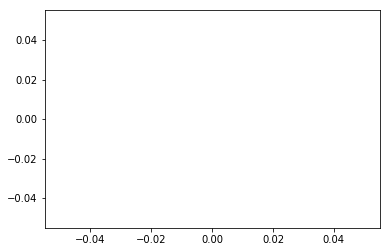

In [32]:
plt.plot(y)